In [2]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0/'


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import matplotlib.pyplot as plt
import datetime

import pickle
import numpy as np

In [4]:
#@title Generate random velocity model

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features

    Features:
    - Horizon layers with natural undulations
    - Curved layers with varying thickness
    - Complex salt bodies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Initialize base velocity model
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate horizon layers with undulations
    num_layers = torch.randint(4, 8, (1,)).item()
    for i in range(num_layers):
        # Layer depth function with undulations
        depth_base = (i + 1) * nz // (num_layers + 1)

        # Add undulations using combination of sine waves
        undulation = (
            10 * torch.sin(2 * np.pi * X[:,:,0] / nx * torch.rand(1, device=device)) +
            10 * torch.cos(2 * np.pi * Y[:,:,0] / ny * torch.rand(1, device=device)) +
            5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny))
        )

        # Add curved component
        curve = 0.1 * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

        # Create layer depth map (2D)
        layer_depth = depth_base + undulation + curve

        # Create 3D layer mask
        base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

        for i_x in range(nx):
            for i_y in range(ny):
                depth = int(layer_depth[i_x, i_y].item())
                if depth < nz:  # Ensure depth is within bounds
                    velocity[i_x, i_y, depth:] = base_vel

    # Add salt bodies with complex shapes
    num_salt = torch.randint(1, 3, (1,)).item()
    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Create salt body with basic ellipsoidal shape
        salt_mask = ((X - x0)**2/rx**2 + (Y - y0)**2/ry**2 + (Z - z0)**2/rz**2) < 1.0

        # Set salt velocity (typically around 4500 m/s)
        velocity[salt_mask] = 4500 + torch.randn(1, device=device) * 100

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)



# Create configuration
cfg = SeismicConfig(
    model_dims=(300, 300, 300),
    v0=1500.0,
    v_min=1500.0,
    v_max=4500.0,
    dv=500.0
)

# Generate velocity model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# velocity_model = create_velocity_model(cfg, device, 0) # [128,128,128]


In [5]:
#@title electrical simulation
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def velocity_to_electrical_field(
    velocity_model: torch.Tensor,
    device: torch.device,
    frequency: float = 1.0,  # Hz
    source_positions: list = None,
    num_sources: int = 4,
    time_steps: int = 1
) -> dict:
    """
    科学地从速度模型计算电场分布和表面测量

    参数:
        velocity_model: 形状为(nx, ny, nz)的3D速度张量
        device: 计算设备(CPU/GPU)
        frequency: 电磁波频率(Hz)
        source_positions: 源位置列表，每个元素为(x,y,z)，默认为None(自动生成)
        num_sources: 如果source_positions为None，则自动生成的源数量
        time_steps: 时间步数，用于时移模拟

    返回:
        包含电场体积数据和表面测量的字典
    """
    nx, ny, nz = velocity_model.shape

    # 步骤1: 岩石物理转换 - 速度到孔隙度
    # 使用简化的经验关系: φ = a * exp(-b * v)，其中φ是孔隙度，v是速度
    a = 0.7  # 最大孔隙度
    b = 0.0004  # 衰减系数 (需要根据实际地质条件校准)

    porosity = a * torch.exp(-b * velocity_model)
    porosity = torch.clamp(porosity, 0.01, 0.6)  # 限制在合理范围

    # 步骤2: 从孔隙度计算电阻率 - 使用Archie方程
    # ρ = a * ρw * φ^(-m)，其中ρw是孔隙水电阻率，m是胶结系数
    water_resistivity = 0.1  # 孔隙水电阻率(欧姆·米)
    cementation_factor = 2.0  # 胶结系数
    tortuosity_factor = 1.0  # 迂曲度因子

    resistivity = tortuosity_factor * water_resistivity * (porosity ** (-cementation_factor))

    # 调整高速度区域(如盐体，通常对应低孔隙度高电阻)
    v_normalized = (velocity_model - velocity_model.min()) / (velocity_model.max() - velocity_model.min())
    high_velocity_mask = v_normalized > 0.8
    resistivity[high_velocity_mask] *= 50  # 盐体电阻率显著更高

    # 计算电导率(S/m)
    conductivity = 1.0 / resistivity

    # 步骤3: 定义电场源(可以是点源、偶极子等)
    if source_positions is None:
        source_positions = []
        spacing = nx // (np.sqrt(num_sources) + 1)

        # 创建表面源网格
        n_side = int(np.sqrt(num_sources))
        for i in range(n_side):
            for j in range(n_side):
                src_x = int((i + 1) * spacing)  # Convert to int
                src_y = int((j + 1) * spacing)  # Convert to int
                src_z = 2  # 靠近表面
                source_positions.append((src_x, src_y, src_z))

    # 步骤4: 使用简化的数值方法计算电场分布
    # 初始化电场数组 - [time, components(Ex,Ey,Ez), nx, ny, nz]
    e_field_volume = torch.zeros(time_steps, 3, nx, ny, nz, device=device)

    # 麦克斯韦方程中的常数
    mu0 = 4 * np.pi * 1e-7  # 真空磁导率
    epsilon0 = 8.85e-12     # 真空电容率
    omega = 2 * np.pi * frequency  # 角频率

    # 对每个时间步长进行计算
    for t in range(time_steps):
        # 可以为时变模拟添加时间因子
        time_factor = 1.0 + 0.05 * torch.sin(torch.tensor(t * 0.2 * np.pi))
        current_conductivity = conductivity * time_factor

        # 累积所有源的贡献
        for source_pos in source_positions:
            src_x, src_y, src_z = source_pos

            # 确保源位置是整数，并在张量边界内
            src_x_idx = min(max(0, int(src_x)), nx-1)
            src_y_idx = min(max(0, int(src_y)), ny-1)
            src_z_idx = min(max(0, int(src_z)), nz-1)

            # 源电流时间变化
            source_amplitude = 1.0 * (1.0 + 0.1 * np.cos(t * 0.5))

            # 计算电位分布 (使用拉普拉斯方程的简化解)
            # 创建到源的距离矩阵
            X, Y, Z = torch.meshgrid(
                torch.arange(nx, device=device),
                torch.arange(ny, device=device),
                torch.arange(nz, device=device),
                indexing='ij'
            )

            r_squared = ((X - src_x_idx)**2 + (Y - src_y_idx)**2 + (Z - src_z_idx)**2)
            r = torch.sqrt(r_squared)
            r[src_x_idx, src_y_idx, src_z_idx] = 1.0  # 避免除零

            # 计算电位场 (使用点电流源的解析解)
            potential = source_amplitude / (4 * np.pi * r)

            # 在电导率不均匀区域应用修正
            # 使用高斯滤波器近似模拟扩散过程
            potential_np = potential.cpu().numpy()
            sigma_np = current_conductivity.cpu().numpy()

            # 迭代求解更准确的电位分布(简化的有限差分法)
            for _ in range(5):
                # 对电位应用拉普拉斯算子修正
                smooth_potential = gaussian_filter(potential_np, sigma=1.0)
                # 根据电导率非均匀性进行调整
                correction = gaussian_filter(potential_np * sigma_np, sigma=1.0) - smooth_potential * gaussian_filter(sigma_np, sigma=1.0)
                potential_np = smooth_potential - 0.1 * correction / (gaussian_filter(sigma_np, sigma=1.0) + 1e-6)

            potential = torch.tensor(potential_np, device=device)

            # 计算电场 (E = -∇V)
            # 使用中心差分计算梯度
            ex = torch.zeros_like(potential)
            ey = torch.zeros_like(potential)
            ez = torch.zeros_like(potential)

            # X方向电场分量
            ex[1:-1, :, :] = -(potential[2:, :, :] - potential[:-2, :, :]) / 2.0
            # 处理边界
            ex[0, :, :] = -(potential[1, :, :] - potential[0, :, :])
            ex[-1, :, :] = -(potential[-1, :, :] - potential[-2, :, :])

            # Y方向电场分量
            ey[:, 1:-1, :] = -(potential[:, 2:, :] - potential[:, :-2, :]) / 2.0
            ey[:, 0, :] = -(potential[:, 1, :] - potential[:, 0, :])
            ey[:, -1, :] = -(potential[:, -1, :] - potential[:, -2, :])

            # Z方向电场分量
            ez[:, :, 1:-1] = -(potential[:, :, 2:] - potential[:, :, :-2]) / 2.0
            ez[:, :, 0] = -(potential[:, :, 1] - potential[:, :, 0])
            ez[:, :, -1] = -(potential[:, :, -1] - potential[:, :, -2])

            # 应用导电介质的特性调整电场
            attenuation = torch.exp(-torch.sqrt(current_conductivity * omega * mu0 * r))

            # 将电场分量添加到主电场数组
            e_field_volume[t, 0, :, :, :] += ex * attenuation
            e_field_volume[t, 1, :, :, :] += ey * attenuation
            e_field_volume[t, 2, :, :, :] += ez * attenuation

    # 步骤5: 提取表面测量
    # 从3D体积中提取表面测量值 (取z=0层)
    surface_measurement = torch.zeros(time_steps, 3, nx, ny, device=device)

    for t in range(time_steps):
        surface_measurement[t, 0, :, :] = e_field_volume[t, 0, :, :, 0]  # Ex at surface
        surface_measurement[t, 1, :, :] = e_field_volume[t, 1, :, :, 0]  # Ey at surface
        surface_measurement[t, 2, :, :] = e_field_volume[t, 2, :, :, 0]  # Ez at surface

        # 计算电场强度
        e_magnitude_volume = torch.sqrt(e_field_volume[:, 0, :, :, :]**2 +
                                      e_field_volume[:, 1, :, :, :]**2 +
                                      e_field_volume[:, 2, :, :, :]**2)

        surface_magnitude = torch.sqrt(surface_measurement[:, 0, :, :]**2 +
                                    surface_measurement[:, 1, :, :]**2 +
                                    surface_measurement[:, 2, :, :]**2)

        # 添加噪声
        noise_level = 0.02
        surface_measurement += noise_level * torch.randn_like(surface_measurement) * surface_magnitude.unsqueeze(1)

        # 对电场强度进行对数变换处理
        # 1. 确保没有零值(添加小的偏移量)
        epsilon = 1e-8  # 小偏移量，避免log(0)错误
        # 2. 对体积电场强度进行对数变换
        log_e_magnitude_volume = torch.log10(e_magnitude_volume + epsilon)
        # 3. 对表面电场强度进行对数变换
        log_surface_magnitude = torch.log10(surface_magnitude + epsilon)

        # 可选: 归一化对数变换后的数据到[0,1]区间，便于可视化
        # 体积归一化
        log_min = log_e_magnitude_volume.min()
        log_max = log_e_magnitude_volume.max()
        normalized_log_e_magnitude = (log_e_magnitude_volume - log_min) / (log_max - log_min)
        # 表面归一化
        log_surf_min = log_surface_magnitude.min()
        log_surf_max = log_surface_magnitude.max()
        normalized_log_surface_magnitude = (log_surface_magnitude - log_surf_min) / (log_surf_max - log_surf_min)

        # 返回结果字典，增加对数变换后的数据
        result = {
            'e_field_volume': e_field_volume,                          # 原始电场向量 [time, components, nx, ny, nz]
            'surface_measurement': surface_measurement,                 # 原始表面测量值 [time, components, nx, ny]
            'e_magnitude_volume': e_magnitude_volume,                   # 原始电场强度 [time, nx, ny, nz]
            'surface_magnitude': surface_magnitude,                     # 原始表面电场强度 [time, nx, ny]
            'log_e_magnitude_volume': log_e_magnitude_volume,           # 对数变换后的电场强度 [time, nx, ny, nz]
            'log_surface_magnitude': log_surface_magnitude,             # 对数变换后的表面电场强度 [time, nx, ny]
            'normalized_log_e_magnitude': normalized_log_e_magnitude,   # 归一化的对数电场强度 [time, nx, ny, nz]
            'normalized_log_surface_magnitude': normalized_log_surface_magnitude,  # 归一化的对数表面电场强度 [time, nx, ny]
            'conductivity_model': conductivity,                         # 电导率模型 [nx, ny, nz]
            'resistivity_model': resistivity,                           # 电阻率模型 [nx, ny, nz]
            'porosity_model': porosity,                                 # 孔隙度模型 [nx, ny, nz]
            'source_positions': source_positions,                       # 源位置列表
            'metadata': {
                'frequency': frequency,
                'time_steps': time_steps,
                'dimensions': (nx, ny, nz),
                'log_transform': {
                    'epsilon': epsilon,
                    'original_range': [float(e_magnitude_volume.min()), float(e_magnitude_volume.max())],
                    'log_range': [float(log_min), float(log_max)]
                }
            }
        }

        return result

def visualize_electrical_results(result, time_idx=0, slice_z=0):
    """
    可视化电场计算结果

    参数:
        result: velocity_to_electrical_field函数的返回值
        time_idx: 要显示的时间索引
        slice_z: 要显示的Z切片索引
    """
    # 提取需要的数据
    conductivity = result['conductivity_model']
    e_field = result['e_field_volume'][time_idx]
    surface_measurement = result['surface_measurement'][time_idx]
    e_magnitude = result['e_magnitude_volume'][time_idx]
    surface_magnitude = result['surface_magnitude'][time_idx]

    plt.figure(figsize=(20, 12))

    # 绘制电导率模型 (Z切片)
    plt.subplot(231)
    plt.imshow(conductivity[:, :, slice_z].cpu().numpy().T, cmap='copper', origin='lower')
    plt.colorbar(label='Conductivity (S/m)')

velocity_model = create_velocity_model(cfg, device, 0)
electrical_model = velocity_to_electrical_field(velocity_model,velocity_model.device)

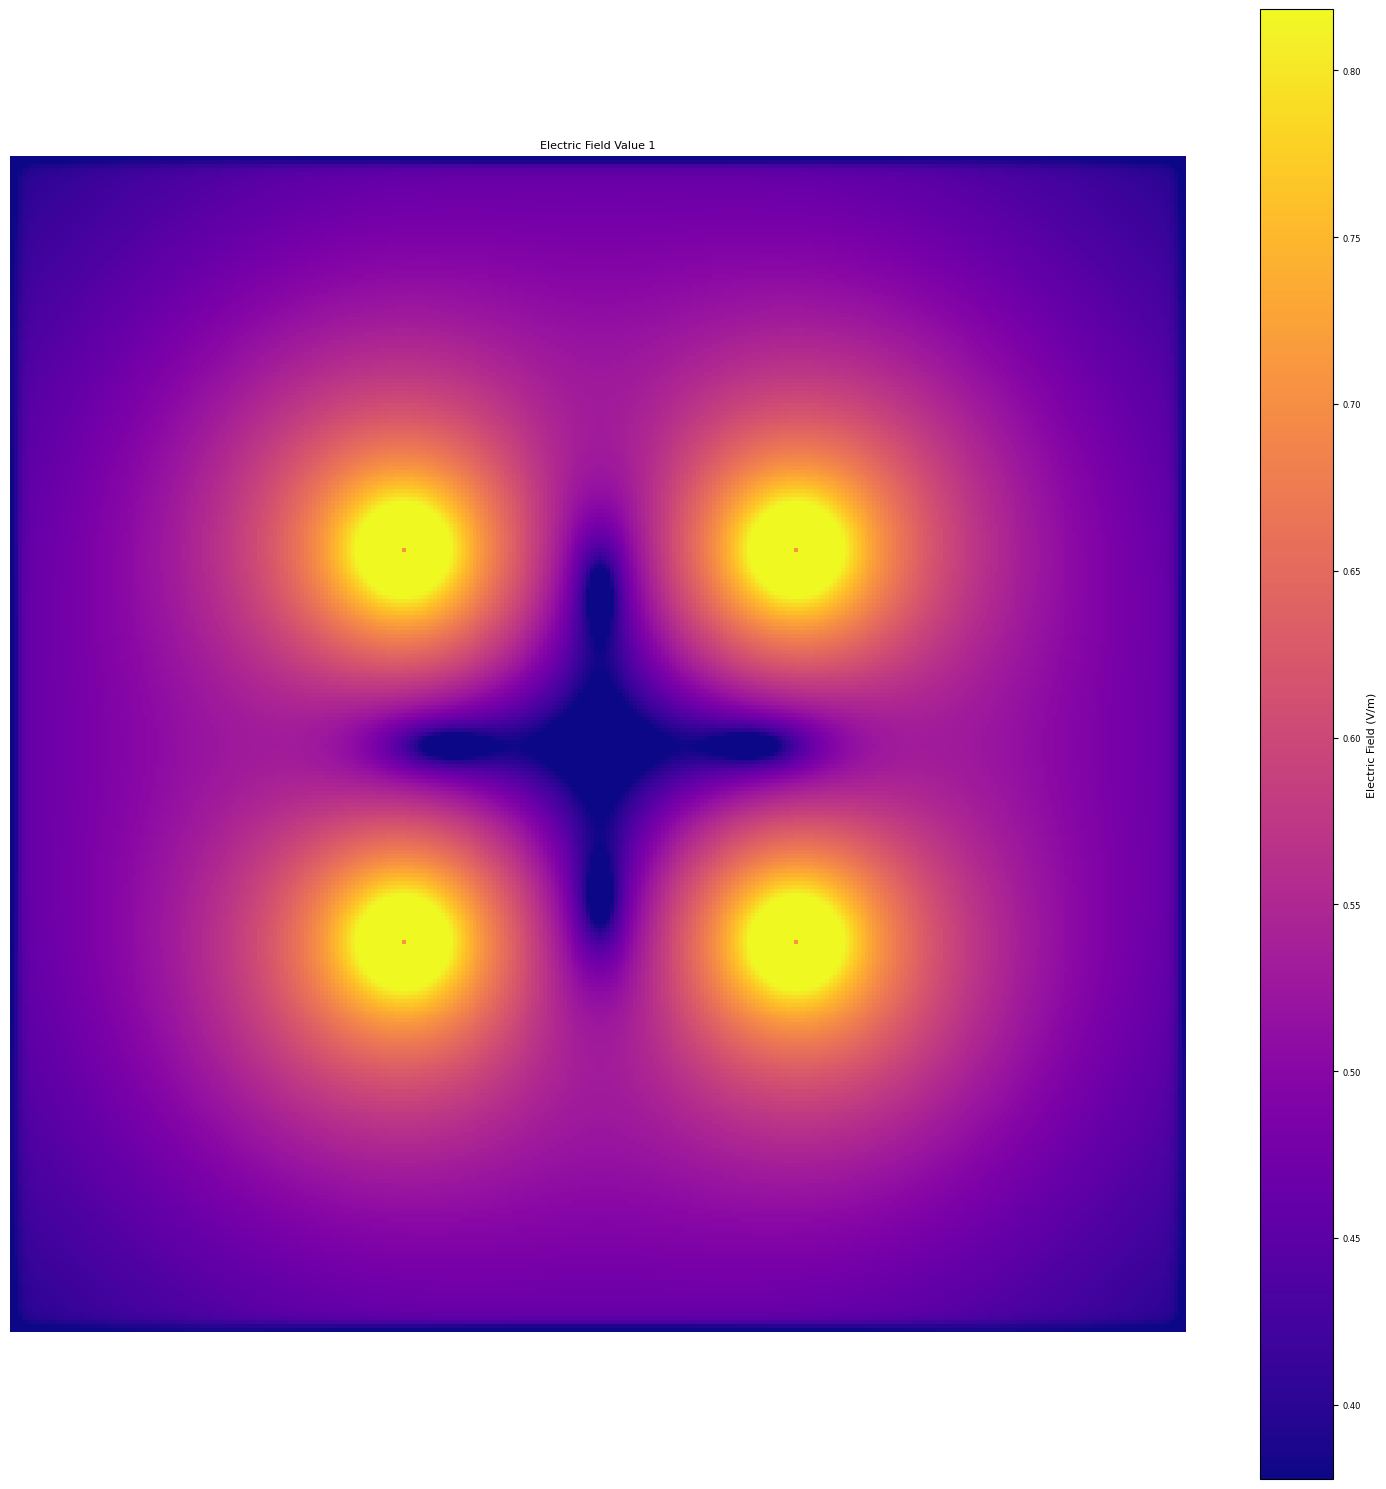

In [6]:
def visualize_data(data, mode='velocity', n_samples=None, figsize=(15, 15), save_path=None, component=None):
    """
    统一的可视化函数，可以绘制速度模型、地震记录、重力数据或电场数据

    参数:
        data: torch.Tensor, 输入数据
            - 速度模型模式: shape为(batch, channel, height, width)
            - 地震记录模式: shape为(batch, time, receivers)
            - 重力数据模式: shape为(batch, height, width) 或 (batch, 1, height, width)
            - 电场数据模式: shape为(batch, components, height, width)或(batch, height, width)
        mode: str, 可选 'velocity', 'seismic', 'gravity' 或 'electrical'
        n_samples: int, 可选，显示多少个样本
        figsize: tuple, 图像大小
        save_path: str, 可选，保存图像的路径
        component: int 或 str, 可选，当mode='electrical'时，指定要显示的分量
                  可以是0/1/2(对应Ex/Ey/Ez)或'magnitude'(电场强度)
    """
    plt.figure(figsize=figsize)
    data = data.detach().cpu()

    # 设置要显示的样本数
    if n_samples is None:
        n_samples = len(data)
    n_samples = min(n_samples, len(data))

    # 计算子图布局
    n_rows = int(np.sqrt(n_samples))
    n_cols = int(np.ceil(n_samples / n_rows))

    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i + 1)

        if mode.lower() == 'velocity':
            # 速度模型可视化
            field = data[i][0].numpy() if data[i].dim() > 2 else data[i].numpy()
            im = plt.imshow(field, cmap='viridis')
            cbar = plt.colorbar(im)
            cbar.set_label('Velocity (m/s)', fontsize=8)
            cbar.ax.tick_params(labelsize=6)
            plt.title(f'Velocity Model {i+1}', fontsize=8)

        elif mode.lower() == 'seismic':
            # 地震记录可视化
            field = data[i]
            # 使用分位数计算每个记录的颜色范围
            vmin, vmax = torch.quantile(field, torch.tensor([0.05, 0.95]))
            im = plt.imshow(field.T,
                          cmap='gray',
                          vmin=vmin,
                          vmax=vmax)
            cbar = plt.colorbar(im)
            cbar.set_label('Amplitude', fontsize=8)
            cbar.ax.tick_params(labelsize=6)
            plt.title(f'Seismic Record {i+1}', fontsize=8)

        elif mode.lower() == 'gravity':
            # 重力数据可视化
            # 处理输入数据形状
            if data[i].dim() > 2:  # 如果是(channel, height, width)形式
                field = data[i][0].numpy() if data[i].dim() == 3 else data[i].squeeze().numpy()
            else:
                field = data[i].numpy()

            # 计算数据范围，使用对称的色标
            abs_max = np.max(np.abs(field))
            vmin, vmax = -abs_max, abs_max

            # 使用地球物理学常用的RdBu_r色标 (红色表示正异常，蓝色表示负异常)
            im = plt.imshow(field, cmap='RdBu_r', vmin=vmin, vmax=vmax)

            # 创建专业的地球物理色标
            cbar = plt.colorbar(im, format='%.1f')
            cbar.set_label('Gravity Anomaly (mGal)', fontsize=8)
            cbar.ax.tick_params(labelsize=6)

            # 添加色标的科学计数格式和精确的刻度
            import matplotlib.ticker as ticker
            if abs_max < 0.1:
                cbar.formatter = ticker.ScalarFormatter(useMathText=True)
                cbar.formatter.set_powerlimits((-2, 2))
                cbar.update_ticks()

            plt.title(f'Gravity Field {i+1}', fontsize=8)

        elif mode.lower() == 'electrical':
            # 电场数据可视化
            # 处理不同的数据形状和分量
            if data[i].dim() > 2:  # 多分量数据 (components, height, width)
                if component is None or component == 'magnitude':
                    # 计算电场强度 (默认)
                    if data[i].shape[0] >= 3:  # 如果有三个分量
                        field = torch.sqrt(data[i][0]**2 + data[i][1]**2 + data[i][2]**2).numpy()
                        component_name = 'Magnitude'
                        cmap = 'hot'  # 电场强度常用热图色标
                        label = 'Electric Field Magnitude (V/m)'
                    else:  # 如果只有一个分量
                        field = data[i][0].numpy()
                        component_name = 'Value'
                        cmap = 'plasma'  # 电导率常用色标
                        label = 'Electric Field (V/m)'
                elif isinstance(component, int) and component < data[i].shape[0]:
                    # 显示特定分量
                    field = data[i][component].numpy()
                    component_names = ['Ex', 'Ey', 'Ez']
                    component_name = component_names[component] if component < len(component_names) else f'Component {component}'
                    cmap = 'seismic'  # 电场分量常用色标(红蓝)
                    label = f'{component_name} (V/m)'
                else:
                    # 默认显示第一个分量
                    field = data[i][0].numpy()
                    component_name = 'Ex'
                    cmap = 'seismic'
                    label = 'Ex (V/m)'
            else:
                # 单分量数据 (height, width)
                field = data[i].numpy()
                component_name = 'Value'
                cmap = 'plasma'  # 电导率常用色标
                label = 'Electric Field (V/m)'

            # 计算数据范围
            # 对于电场分量使用对称色标，对于电场强度和电导率使用非对称色标
            if cmap == 'seismic':
                abs_max = np.max(np.abs(field))
                vmin, vmax = -abs_max, abs_max
            else:
                # 使用分位数避免极端值影响可视化
                vmin, vmax = np.percentile(field, [2, 98])
                vmin = max(0, vmin)  # 电场强度和电导率通常为非负值

            # 绘制电场数据
            im = plt.imshow(field, cmap=cmap, vmin=vmin, vmax=vmax)

            # 创建专业的地球物理色标
            cbar = plt.colorbar(im)
            cbar.set_label(label, fontsize=8)
            cbar.ax.tick_params(labelsize=6)

            # 添加科学计数格式
            import matplotlib.ticker as ticker
            if vmax < 0.01 or vmax > 1000:
                cbar.formatter = ticker.ScalarFormatter(useMathText=True)
                cbar.formatter.set_powerlimits((-2, 2))
                cbar.update_ticks()

            plt.title(f'Electric Field {component_name} {i+1}', fontsize=8)

        else:
            raise ValueError("mode must be 'velocity', 'seismic', 'gravity', or 'electrical'")

        plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

visualize_data(electrical_model['normalized_log_surface_magnitude'],mode='electrical',save_path=f_path+"normalized_log_surface_magnitude_visualization_seed0.pdf")

<ipython-input-7-14d0456f83a4>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Figure saved as '/content/drive/MyDrive/DiTing2.0/normalized_log_e_magnitude_visualization_seed0.pdf'


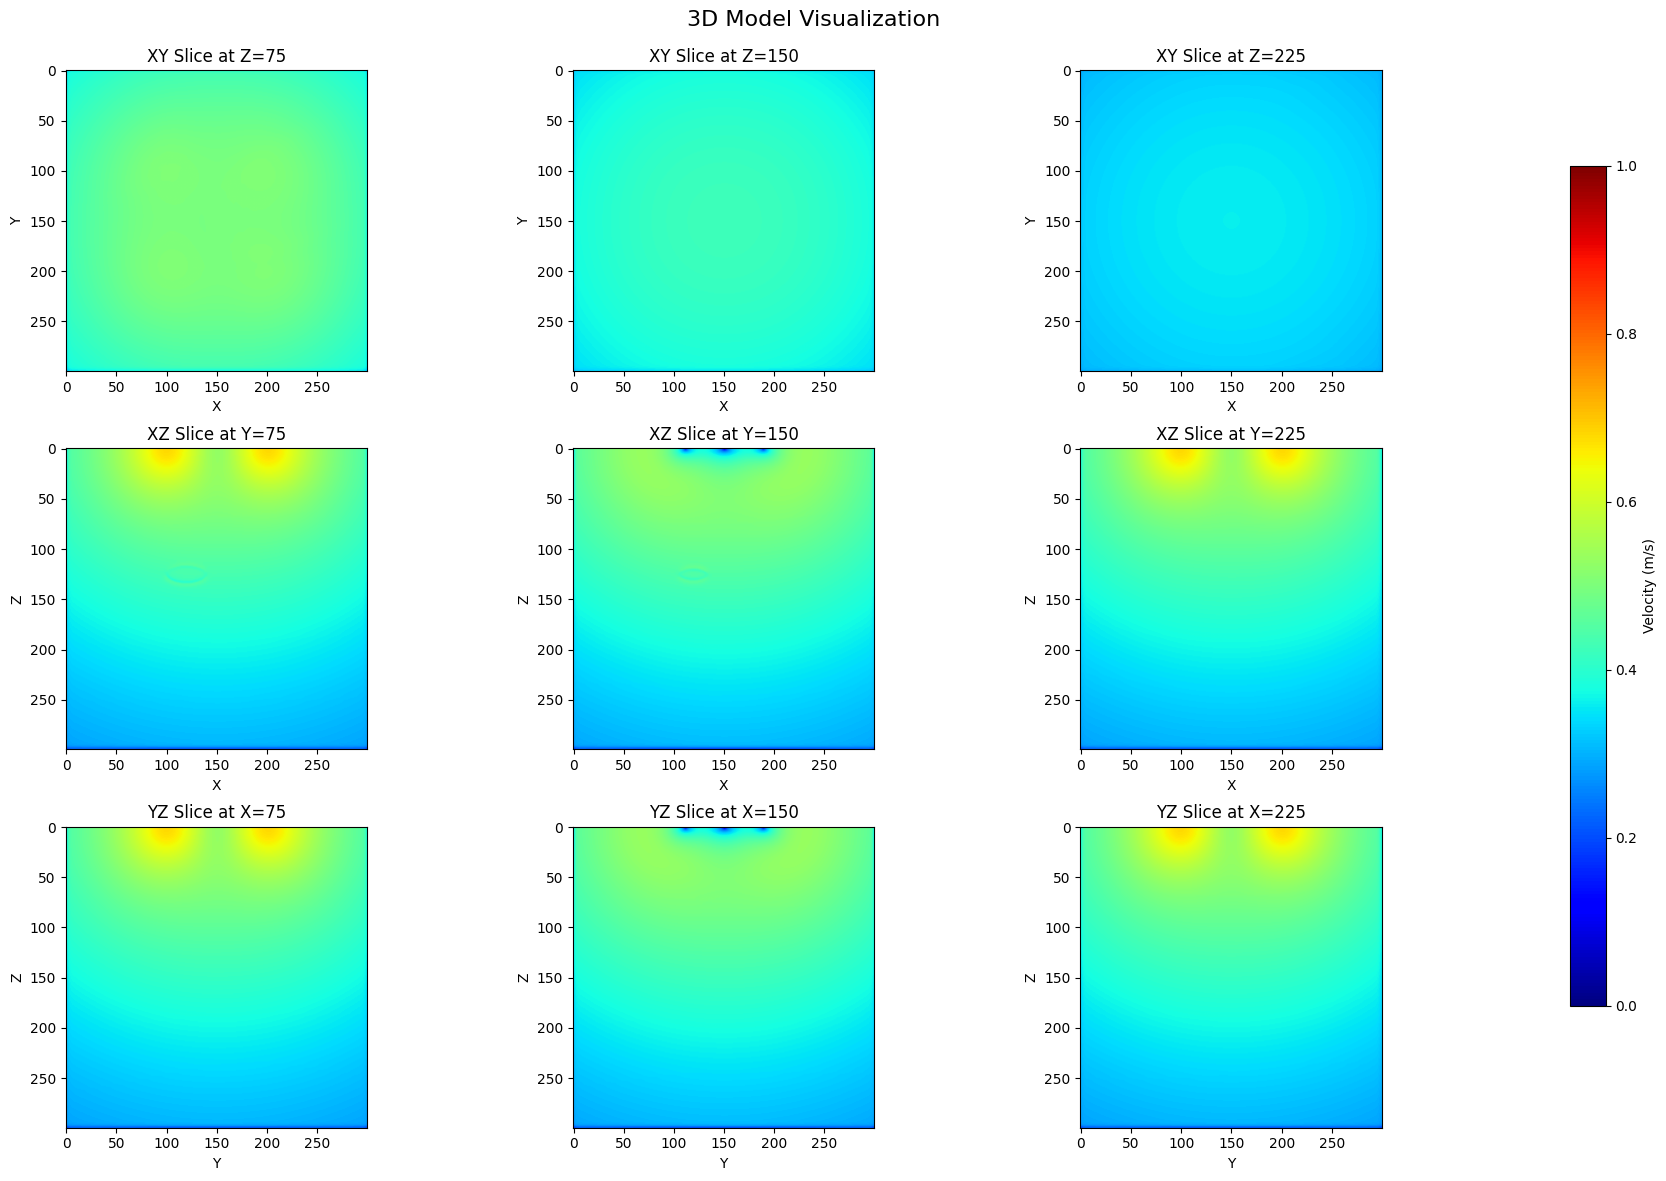

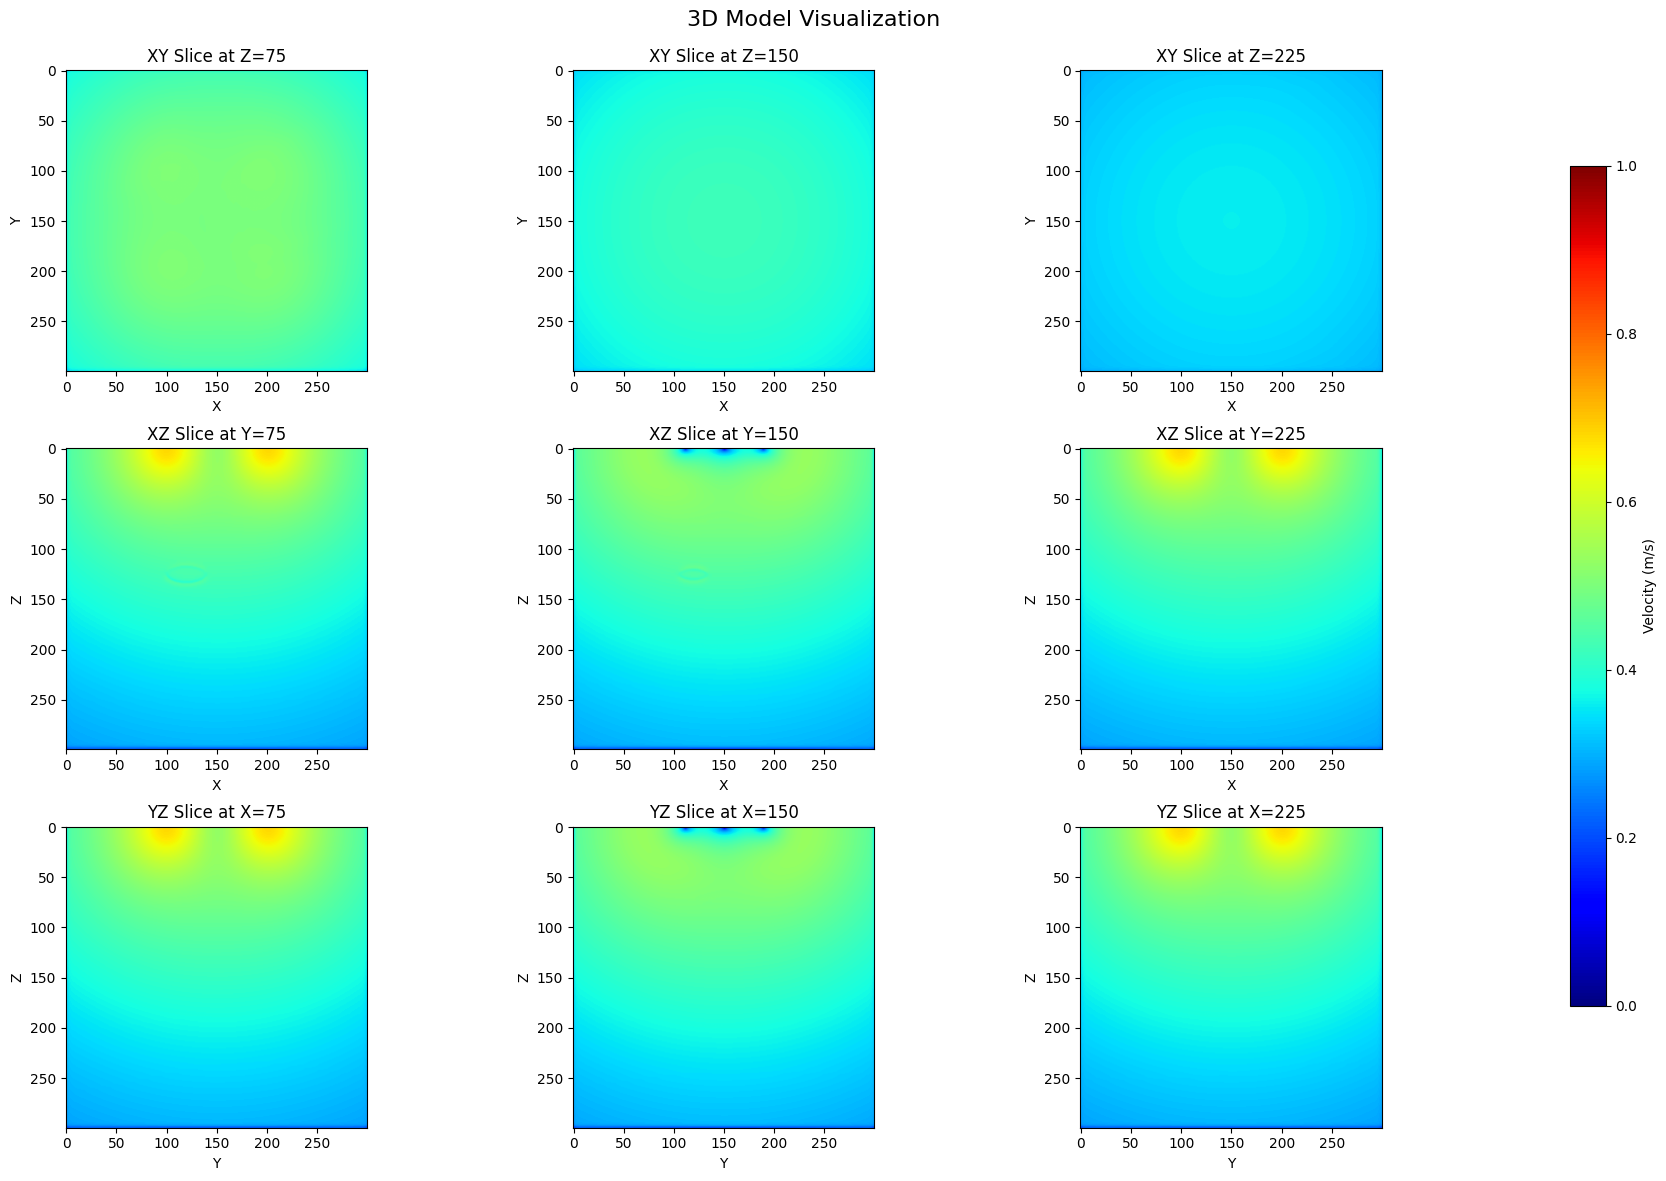

In [7]:
#@title 3D velocity model visulization
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_comprehensive(velocity_model, save_pdf=False, filename=f_path+"gravity_model_visualization_seed0.pdf"):
    """
    Comprehensive visualization of 3D velocity model with multiple views

    Parameters:
    -----------
    velocity_model : torch.Tensor
        The 3D velocity model to visualize
    save_pdf : bool, optional
        Whether to save the figure as PDF (default: False)
    filename : str, optional
        Name of the PDF file to save (default: "velocity_model_visualization.pdf")

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create figure
    fig = plt.figure(figsize=(18, 12))

    # Define colormap and normalization
    cmap = plt.cm.jet
    norm = Normalize(vmin=vel.min(), vmax=vel.max())

    # 1. XY slices at different depths
    depths = [nz//4, nz//2, 3*nz//4]
    for i, depth in enumerate(depths):
        ax = fig.add_subplot(3, 3, i+1)
        im = ax.imshow(vel[:, :, depth], cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice at Z={depth}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # 2. XZ slices at different Y positions
    y_positions = [ny//4, ny//2, 3*ny//4]
    for i, y_pos in enumerate(y_positions):
        ax = fig.add_subplot(3, 3, i+4)
        im = ax.imshow(vel[:, y_pos, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice at Y={y_pos}')
        ax.set_xlabel('X')
        ax.set_ylabel('Z')

    # 3. YZ slices at different X positions
    x_positions = [nx//4, nx//2, 3*nx//4]
    for i, x_pos in enumerate(x_positions):
        ax = fig.add_subplot(3, 3, i+7)
        im = ax.imshow(vel[x_pos, :, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice at X={x_pos}')
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Velocity (m/s)')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.suptitle('3D Model Visualization', fontsize=16)
    plt.subplots_adjust(top=0.93)

    # Save figure as PDF if requested
    if save_pdf:
        plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Figure saved as '{filename}'")

    plt.show()

    return fig

# Visualize the model
visualize_model_comprehensive(electrical_model['normalized_log_e_magnitude'].squeeze(0),save_pdf=True,filename=f_path+"normalized_log_e_magnitude_visualization_seed0.pdf")


In [9]:
electrical_model['e_magnitude_volume'].shape

torch.Size([1, 300, 300, 300])